In [3]:
%matplotlib inline

In [26]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib import rcParams

import numpy as np
import pandas as pd


import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import dask.dataframe as dd
import dask.bag as db
import dask.diagnostics as dg

import geopandas as gpd
from blume.table import table



paper_path = Path('../../paper/figures/')

slide_path = Path('../../slides/figures/intro/')
#rcParams['font.family'] = 'Segoe Print'

In [27]:
YEAR = 2021
names = ['ID', 'DATE', 'ELEMENT', 'DATA_VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']
ds = dd.read_csv(f's3://noaa-ghcn-pds/csv/{YEAR}.csv', storage_options={'anon':True},  names=names, memory_map=False, 
                  dtype={'DATA_VALUE':'object'}, parse_dates=['DATE', 'OBS-TIME'])

In [28]:
# {column name:extents of the fixed-width fields}
columns = {"ID": (0,11), "LATITUDE": (12, 20), "LONGITUDE": (21, 30), "ELEVATION": (31, 37),"STATE": (38, 40),
           "NAME": (41, 71), "GSN FLAG": (72, 75), "HCN/CRN FLAG": (76, 79),"WMO ID": (80, 85)}

In [29]:
df = pd.read_fwf("http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt", 
                    colspecs=list(columns.values()), names=list(columns.keys())).dropna(subset=['STATE'])

In [30]:
nydf = df[df['STATE'].str.match("NY")]

In [31]:
nyds = ds[ds['ID'].isin(nydf['ID'].unique()) & ds['ELEMENT'].str.match('TAVG')].compute()

In [32]:
ny = nyds.merge(nydf, on='ID')

In [33]:
ny.to_csv("nydata", index=False)

In [34]:
ny = pd.read_csv("nydata")

In [35]:
ny['TAVG'] = (ny['DATA_VALUE'].astype(float)/10) *(9/5) + 32

In [36]:
ny['DATES'] = pd.to_datetime(ny['DATE'])

In [37]:
nymap = ny.groupby('NAME').agg({'TAVG':'std', 'LATITUDE':'mean', 'LONGITUDE':'mean'})

In [38]:
nygdf = gpd.GeoDataFrame(nymap['TAVG'],  geometry=gpd.points_from_xy(nymap['LONGITUDE'], nymap['LATITUDE']))

In [39]:
dfs = ny[['DATE', 'LATITUDE', 'LONGITUDE', 'TAVG']].sort_values(by='DATE').head(5)

In [40]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', 
                                         category='cultural', name=shapename)
nystate = gpd.read_file(states_shp)

C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:247: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  l, b, w, h = bbox.inverse_transformed(self.get_data_transform()).bounds
C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:525: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  return bbox.inverse_transformed(self.get_transform())
C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:247: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  l, b, w, h = bbox.inverse_transformed(self.get_data_transform

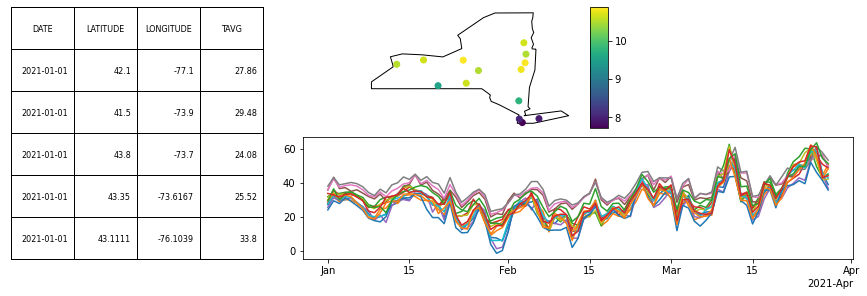

In [41]:
fig, axd = plt.subplot_mosaic([['table', 'map', '.'],
                               ['table', 'time', 'time']], 
                              constrained_layout=True, figsize=(12,4))
table(axd['table'], cellText=dfs.astype('str').values, colLabels=dfs.columns, fontsize=12, bbox=(0, 0, 1, 1))
axd['table'].set(xticks=[], yticks=[], aspect='equal')
for name, df in ny.groupby(['NAME']):
    axd['time'].plot('DATES', 'TAVG', data=df, label=name)

axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

nystate[nystate['postal'].str.match('NY')].plot(ax=axd['map'], facecolor='white', edgecolor='k')
nygdf.plot('TAVG', ax=axd['map'], legend=True)
axd['map'].set_aspect('equal')
axd['map'].axis('off')
fig.savefig(slide_path/"time.png")



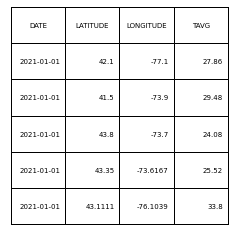

In [42]:
fig, ax = plt.subplots()
table(ax, cellText=dfs.astype('str').values, colLabels=dfs.columns, fontsize=12, bbox=(0, 0, 1, 1))
ax.set(xticks=[], yticks=[], aspect='equal')
fig.savefig(slide_path/"table.png", bbox_inches='tight')

C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:247: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  l, b, w, h = bbox.inverse_transformed(self.get_data_transform()).bounds
C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:525: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  return bbox.inverse_transformed(self.get_transform())
C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:247: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  l, b, w, h = bbox.inverse_transformed(self.get_data_transform

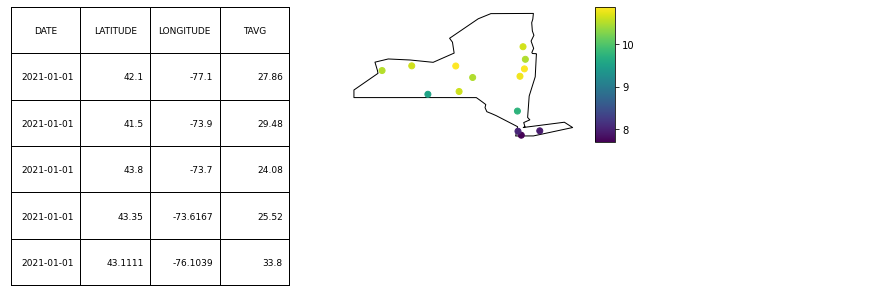

In [43]:
fig, axd = plt.subplot_mosaic([['table', 'map', '.'],
                               ['table', 'time', 'time']], 
                              constrained_layout=True, figsize=(12,4))
table(axd['table'], cellText=dfs.astype('str').values, colLabels=dfs.columns, fontsize=12, bbox=(0, 0, 1, 1))
axd['table'].set(xticks=[], yticks=[], aspect='equal')
nystate[nystate['postal'].str.match('NY')].plot(ax=axd['map'], facecolor='white', edgecolor='k')
nygdf.plot('TAVG', ax=axd['map'], legend=True)
axd['map'].set_aspect('equal')
axd['map'].axis('off')
axd['time'].axis('off')
fig.savefig(slide_path/"map.png")

C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:247: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  l, b, w, h = bbox.inverse_transformed(self.get_data_transform()).bounds
C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:525: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  return bbox.inverse_transformed(self.get_transform())
C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:247: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  l, b, w, h = bbox.inverse_transformed(self.get_data_transform

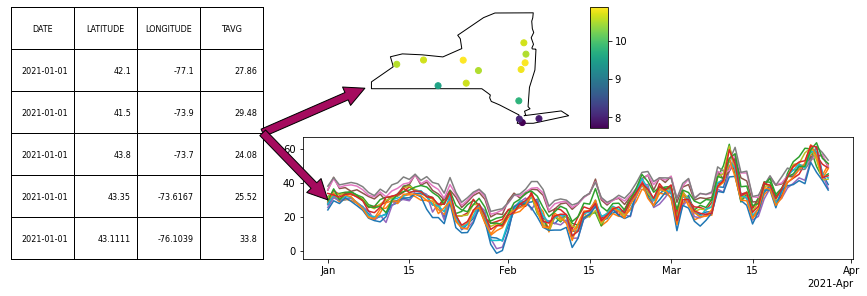

In [44]:
fig, axd = plt.subplot_mosaic([['table', 'map', '.'],
                               ['table', 'time', 'time']], 
                              constrained_layout=True, figsize=(12,4))
table(axd['table'], cellText=dfs.astype('str').values, colLabels=dfs.columns, fontsize=12, bbox=(0, 0, 1, 1))
axd['table'].set(xticks=[], yticks=[], aspect='equal')
for name, df in ny.groupby(['NAME']):
    axd['time'].plot('DATES', 'TAVG', data=df, label=name)

axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

nystate[nystate['postal'].str.match('NY')].plot(ax=axd['map'], facecolor='white', edgecolor='k')
nygdf.plot('TAVG', ax=axd['map'], legend=True)
axd['map'].set_aspect('equal')
axd['map'].axis('off')

con_tmap = mpatches.ConnectionPatch(xyA=(1,.5), coordsA=axd['table'].transData,
                        xyB=(-80, 42), coordsB=axd['map'].transData,   
                         arrowstyle="simple", mutation_scale=40, 
                        facecolor='#A50B5E', edgecolor='k')
fig.add_artist(con_tmap)

con_ttime = mpatches.ConnectionPatch(xyA=(1,.5), coordsA=axd['table'].transData,
                        xyB=(18628.0, 30), coordsB=axd['time'].transData,   
                         arrowstyle="simple", mutation_scale=40, 
                        facecolor='#A50B5E', edgecolor='k')
fig.add_artist(con_ttime)



fig.savefig(slide_path/"artist.png")

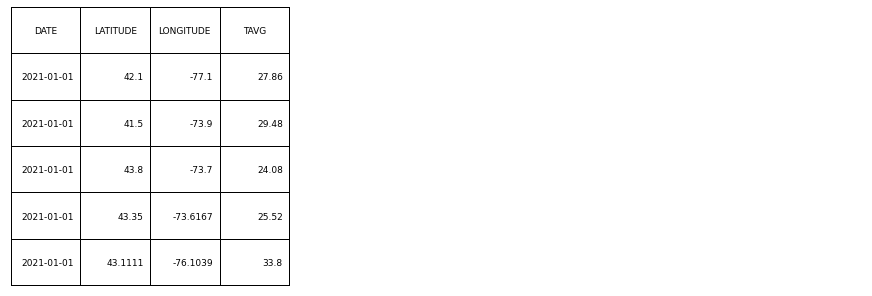

In [45]:
fig, axd = plt.subplot_mosaic([['table', 'map', '.'],
                               ['table', 'time', 'time']], 
                              constrained_layout=True, figsize=(12,4))
table(axd['table'], cellText=dfs.astype('str').values, colLabels=dfs.columns, fontsize=12, bbox=(0, 0, 1, 1))
axd['table'].set(xticks=[], yticks=[], aspect='equal')
axd['time'].axis('off')
axd['map'].axis('off')
fig.savefig(slide_path/"table_only.png")

In [46]:
import matplotlib.colors as mcolors
import matplotlib.cm as mcm


In [47]:
dfs['color'] = ['xkcd:plum', 'xkcd:darkblue', 'xkcd:magenta', 'xkcd:green', 'xkcd:tomato']

In [48]:
# 14 colors
nygdf['colors'] = ['indianred', 'darkred', 'peru', 'olivedrab', 
                   'greenyellow', 'palegreen', 'darkslategray', 'darkcyan', 
                   'deepskyblue', 'dodgerblue', 'midnightblue', 'indigo', 
                   'mediumvioletred', 'rebeccapurple']

In [49]:
nyjfk = ny[ny['NAME'].str.contains("JFK")]
norm = mcolors.Normalize(vmin=nyjfk['TAVG'].min(), vmax=nyjfk['TAVG'].max())
cmap = mcm.viridis

In [50]:
def make_plot(dfs, nyjfk, nygdf, saveout):
    fig, axd = plt.subplot_mosaic([['table', 'map', '.'],
                               ['table', 'time', 'time']], 
                              constrained_layout=True, figsize=(12,4))
    tab = axd['table'].table(cellText=dfs[['DATE', 'LATITUDE', 'LONGITUDE', 'TAVG']].astype('str').values,
                    colLabels=dfs.columns, bbox=(0, 0, 1, 1))
    tab.set_fontsize('xx-large')
    for i, color in enumerate(['tab:blue', 'tab:orange', 'tab:orange', 'white']):
        for j in range(len(dfs)+1):
            tab[(j, i)].set_color(color)
            tab[(j,i)].get_text().set_color("white")
            tab[(j,i)].set_edgecolor("black")
            #tab[(j, i)].get_text().set_fontsize(54)

    for c in range(4):
        tab[(0,c)].get_text().set_color("black")
        tab[(0,c)].set_facecolor("white")
        tab[(0,c)].set_edgecolor("black")

    for j, color in enumerate(dfs['color']):
        tab[(j+1,3)].set_color(color)
    #tab[(j+1, i)].get_text().set_color(color)

    axd['table'].set(xticks=[], yticks=[], aspect='equal')

    nystate[nystate['postal'].str.match('NY')].plot(ax=axd['map'], facecolor='white', edgecolor='k')
    nygdf.plot('colors', edgecolor='tab:orange', ax=axd['map'])
    axd['map'].set_aspect('equal')
    axd['map'].axis('off')

    axd['time'].plot('DATES', 'TAVG', data=nyjfk, color='tab:blue')
    axd['time'].scatter('DATE', 'TAVG', c=nyjfk['TAVG'], data=nyjfk, cmap=cmap, norm=norm, zorder=10)

    axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    fig.savefig(paper_path/saveout)

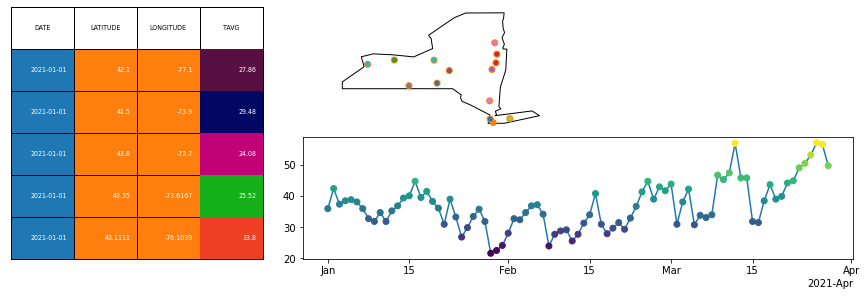

In [51]:
make_plot(dfs, nyjfk, nygdf, "data.png")

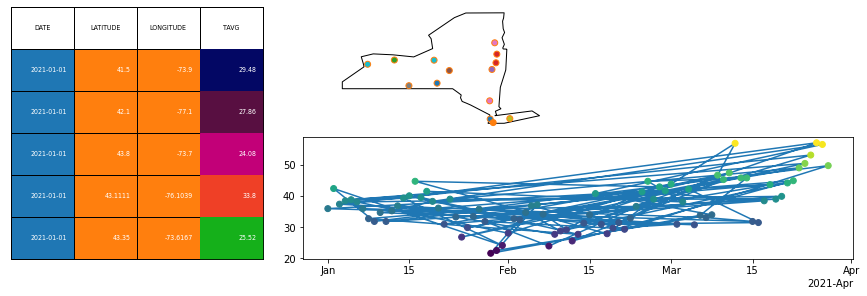

In [52]:
make_plot(dfs.sample(frac=1), nyjfk.sample(frac=1), nygdf.sample(frac=1), "continuity")

In [316]:
def plot_table(ax, dfs, ccolors):
    tab = ax.table(cellText=dfs.astype('str').values, cellLoc='center',
                   colLabels=dfs.columns, bbox=(0, 0, 1, 1))
    tab.set_fontsize('xx-large')
    for i, color in enumerate(ccolors):
        for j in range(len(dfs)+1):
            tab[(j,i)].get_text().set_color(color)
            tab[(j,i)].set_edgecolor("black")    

    ax.set(xticks=[], yticks=[], aspect='equal')
    return tab

In [317]:
nyjfk['TAVG2'] = nyjfk['TAVG']*2
dfs = nyjfk.iloc[10:15]

<ipython-input-317-db8e4204328c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyjfk['TAVG2'] = nyjfk['TAVG']*2


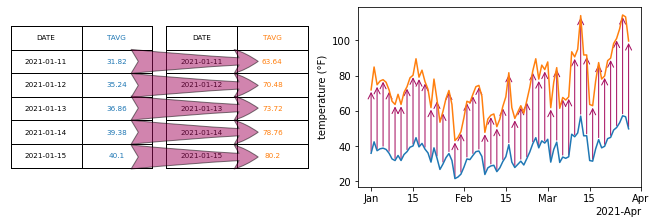

In [376]:
fig, axd = plt.subplot_mosaic([['tab1','tab2', 'time']], gridspec_kw={'width_ratios':[1,1,2]},
                              constrained_layout=True, figsize=(9,3))

tab = plot_table(axd['tab1'], dfs[['DATE', 'TAVG']], ['k', 'tab:blue'])
tab2 = plot_table(axd['tab2'], dfs[['DATE', 'TAVG2']], ['k','tab:orange'])
tab2[(0,1)].get_text().set_text('TAVG')
axd['time'].plot('DATES', 'TAVG', data=nyjfk, color='tab:blue')
axd['time'].plot('DATES', 'TAVG2', data=nyjfk, color='tab:orange')
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
axd['time'].set_ylabel("temperature (°F)")

for y in [.075, .25, .42, .58, .75]:
    con_ft = mpatches.ConnectionPatch(xyA=(.85,y), coordsA=axd['tab1'].transData,
                            xyB=(.65, y), coordsB=axd['tab2'].transData,   
                             arrowstyle="fancy", mutation_scale=60, 
                            facecolor='#A50B5E', edgecolor='black', alpha=.5)
    fig.add_artist(con_ft)
    
for (i, (d, t1, t2)) in nyjfk[['DATES', 'TAVG', 'TAVG2']].iloc[::2].iterrows():
    a1 = mpatches.FancyArrowPatch((d, t1), (d,t2), arrowstyle="->",  
                                  linestyle=None, mutation_scale=15, color='#A50B5E')
    axd['time'].add_artist(a1)
fig.savefig(paper_path/"equivariance.png")

In [377]:
table = np.array([["sun", 1], ["clouds", 4], ['rain', 2], ['lightning', 3], ['storm', 2]])

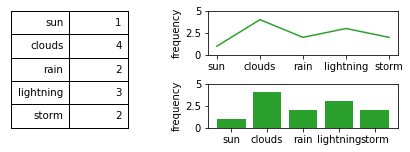

In [378]:
fig, axd = plt.subplot_mosaic([['tab','plot'], ['tab', 'bar']], gridspec_kw={'width_ratios':[1,1]}, 
                              constrained_layout=True, figsize=(6,2))

tab = axd['tab'].table(cellText=table.astype('str'), bbox=(0, 0, 1, 1))
tab.set_fontsize('xx-large')
axd['tab'].set(xticks=[], yticks=[], aspect='equal')
axd['plot'].plot(table[:,0], table[:,1].astype(int), color='tab:green')
axd['bar'].bar(table[:,0], table[:,1].astype(int), color='tab:green')
for n in ['bar', 'plot']:
    #axd[n].set_ylim(0,4.1)
    axd[n].set_ylabel("frequency")
    axd[n].xaxis.set_tick_params(rotation=0)
    axd[n].set_yticks([0, 2.5, 5])
    axd[n].set_yticklabels(['0', '2.5', '5'])
axd['bar'].set_ylim(0,5)
axd['plot'].set_ylim(0, 5)

fig.savefig(paper_path/"continuity.png")

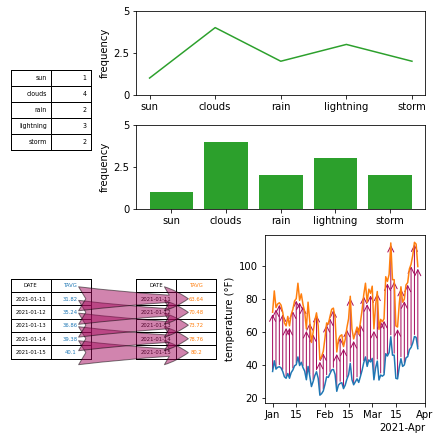

In [375]:
fig, axd = plt.subplot_mosaic([ ['tab','plot', 'plot'], 
                                ['tab', 'bar', 'bar'], 
                                ['tab1','tab2', 'time'], 
                              
                              ], gridspec_kw={'width_ratios':[1,1,2], 'height_ratios':[1,1,2]},
                              constrained_layout=True, figsize=(6,6))

tab = plot_table(axd['tab1'], dfs[['DATE', 'TAVG']], ['k', 'tab:blue'])
tab2 = plot_table(axd['tab2'], dfs[['DATE', 'TAVG2']], ['k','tab:orange'])
tab2[(0,1)].get_text().set_text('TAVG')
axd['time'].plot('DATES', 'TAVG', data=nyjfk, color='tab:blue')
axd['time'].plot('DATES', 'TAVG2', data=nyjfk, color='tab:orange')
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
axd['time'].set_ylabel("temperature (°F)")

for y in [.075, .25, .42, .58, .75]:
    con_ft = mpatches.ConnectionPatch(xyA=(.85,y), coordsA=axd['tab1'].transData,
                            xyB=(.65, y), coordsB=axd['tab2'].transData,   
                             arrowstyle="fancy", mutation_scale=60, 
                            facecolor='#A50B5E', edgecolor='black', alpha=.5)
    fig.add_artist(con_ft)
    
for (i, (d, t1, t2)) in nyjfk[['DATES', 'TAVG', 'TAVG2']].iloc[::2].iterrows():
    a1 = mpatches.FancyArrowPatch((d, t1), (d,t2), arrowstyle="->",  
                                  linestyle=None, mutation_scale=15, color='#A50B5E')
    axd['time'].add_artist(a1)
    

tab = axd['tab'].table(cellText=table.astype('str'), bbox=(0, 0, 1, 1))
tab.set_fontsize('xx-large')
axd['tab'].set(xticks=[], yticks=[], aspect='equal')
axd['plot'].plot(table[:,0], table[:,1].astype(int), color='tab:green')
axd['bar'].bar(table[:,0], table[:,1].astype(int), color='tab:green')
for n in ['bar', 'plot']:
    #axd[n].set_ylim(0,4.1)
    axd[n].set_ylabel("frequency")
    axd[n].xaxis.set_tick_params(rotation=0)
    axd[n].set_yticks([0, 2.5, 5])
    axd[n].set_yticklabels(['0', '2.5', '5'])
axd['bar'].set_ylim(0,5)
axd['plot'].set_ylim(0, 5)
fig.savefig(paper_path/"structure.png")